# PRÁCTICA 2: Análisis de información textual en Youtube

# 1) Extracción de datos de youtube

En este primer apartado nos piden obtener para diferentes canales el título de sus videos, descripción, fecha de publicación y comentarios mediante la API de Youtube.

In [1]:
from googleapiclient.errors import HttpError

El primer paso es construir la conexión con la API mediante nuestra API KEY

In [ ]:
from googleapiclient.discovery import build

API_KEY = "API_KEY_HERE"
youtube = build("youtube", "v3", developerKey=API_KEY)


La API de YouTube funciona mediante peticiones REST que devuelven respuestas en formato JSON. Cada recurso (videos, canales, playlists, comentarios, etc.) tiene endpoints específicos con diferentes métodos (list, insert, update, delete).
El parámetro part especifica qué campos del recurso queremos obtener. Los principales son:

snippet: información básica (título, descripción, fecha de publicación, miniaturas)
contentDetails: detalles del contenido (duración, resolución, región)
statistics: estadísticas (vistas, likes, comentarios)

La API tiene cuotas de uso: cada petición consume unidades dependiendo de los recursos solicitados. Es importante optimizar las llamadas agrupando peticiones cuando sea posible.

Vamos a verlo con un ejemplo, vamos a descargar la información de un video concreto y nos vamos a quedar con los campos del JSON `snippet`, `contentDetails`, `statistics`.
```
{
  "kind": "youtube#video",
  "etag": etag,
  "id": string,
  "snippet": {
    "publishedAt": datetime,
    "channelId": string,
    "title": string,
    "description": string,
    "thumbnails": {
      (key): {
        "url": string,
        "width": unsigned integer,
        "height": unsigned integer
      }
    },
    "channelTitle": string,
    "tags": [
      string
    ],
    "categoryId": string,
    "liveBroadcastContent": string,
    "defaultLanguage": string,
    "localized": {
      "title": string,
      "description": string
    },
    "defaultAudioLanguage": string
  },
  "contentDetails": {
    "duration": string,
    "dimension": string,
    "definition": string,
    "caption": string,
    "licensedContent": boolean,
    "regionRestriction": {
      "allowed": [
        string
      ],
      "blocked": [
        string
      ]
    },
    "contentRating": {
      "acbRating": string,
      ...
    },
    "projection": string,
    "hasCustomThumbnail": boolean
  },
  "statistics": {
    "viewCount": string,
    "likeCount": string,
    "dislikeCount": string,
    "favoriteCount": string,
    "commentCount": string
  }
```

In [18]:
r = youtube.videos().list(part="snippet,contentDetails,statistics", id="5R3kIhZsI38").execute()

In [ ]:
type(r)

dict

In [21]:
r

{'kind': 'youtube#videoListResponse',
 'etag': 'sG7wbnL43NYnT4TZLP-Qa78D3K4',
 'items': [{'kind': 'youtube#video',
   'etag': 'UwsCTfWX2acpiYtNOnFbUPUf-2E',
   'id': '5R3kIhZsI38',
   'snippet': {'publishedAt': '2026-01-02T20:03:44Z',
    'channelId': 'UC8LeXCWOalN8SxlrPcG-PaQ',
    'title': 'El futuro de la programación según cofundador de OpenAI',
    'description': '¿Estamos viviendo el fin de la programación tal como la conocemos? Boris Cherny (creador de Claude Code) dice que ya no abre su IDE. Andrej Karpathy se siente "atrasado". En este video analizamos cómo el "Bive Coding" nos lleva al 95% del trabajo, pero por qué ese 5% restante es el que realmente separa a los ingenieros de los simples "copiadores" de prompts.',
    'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/5R3kIhZsI38/default.jpg',
      'width': 120,
      'height': 90},
     'medium': {'url': 'https://i.ytimg.com/vi/5R3kIhZsI38/mqdefault.jpg',
      'width': 320,
      'height': 180},
     'high': {'url'

Sabiendo esto, es facil ver que si nos queremos quedar solamente con, por ejemplo la descripción simplemente tenemos que filtrar el diccionario de la respuesta con lo que neceitamos, por ejemplo esta función se queda solamente con la descripción de un video.

In [ ]:
def get_video_description(video_id: str) -> str:
    resp = youtube.videos().list(
        part="snippet",
        id=video_id
    ).execute()

    items = resp.get("items", [])

    return items[0]["snippet"].get("description", "")

print(get_video_description("5R3kIhZsI38"))

¿Estamos viviendo el fin de la programación tal como la conocemos? Boris Cherny (creador de Claude Code) dice que ya no abre su IDE. Andrej Karpathy se siente "atrasado". En este video analizamos cómo el "Bive Coding" nos lleva al 95% del trabajo, pero por qué ese 5% restante es el que realmente separa a los ingenieros de los simples "copiadores" de prompts.


Hasta ahora, hemos obtenido la información de un video, pero esto es muy ineficiente si queremos obtener todos los videos de un canal ¿Tendríamos que sacar el id de cada video a mano? Obviamente no, la API nos ofrece [uploads](https://developers.google.com/youtube/v3/docs/channels#contentDetails.relatedPlaylists.uploads), una playlist en la que tenemos todos los videos subidos al canal.

Para extraer los comentarios usamos [commentThreads().list()](https://developers.google.com/youtube/v3/docs/commentThreads) con el parámetro order="relevance" para obtener los comentarios más relevantes.

Se nos pide para cada canal descargar 100 vídeos, para elegir esos 100 vídeos vamos a filtrar de todos los videos los que tengan mínimo 20 comentarios, una descripción de al menos 50 caracteres y una duración mínima de 300 segundos (5 minutos), esto para qudarnos con videos que contengan suficiente información y nos sirvan para los siguientes apartados. Una vez seleccionados todos los videos del canal que cumplen esas características, seleccionamos 100 videos distribuidos uniformemente de manera temporal usando bins de tiempo. Esto se explicará más adelante.

Por lo tanto, la idea para extraer los videos sería:

1º) Obtener el id de la playlist upload que tiene todos los videos

2º) Obtener todos los elementos de la playlist, los elementos de la playlist tienen algunos datos básicos como título, fecha y descripción, pero le falta commentCount, duración y demás, por lo que únicamente nos quedamos con los id de los videos de la playlist para luego obtener toda la información completa de cada video. [docs](https://developers.google.com/youtube/v3/docs/playlistItems#resource)

3º) Para cada video del canal que hemos obtenido en el paso anterior sacar la información completa

4º) Aplicar heurística (1º) Filtrar videos que cumplan las características (2º) Seleccionar videos por bins de tiempo

5º) Obtener comentarios de los 100 videos con los que nos hemos quedado

Vamos a hacer una prueba del código con un solo canal, para ver que funciona, primero obtener los videos que cumplen las condiciones

In [ ]:
import re

def get_uploads_playlist_id(channel_id: str) -> str:
    r = youtube.channels().list(part="contentDetails", id=channel_id).execute()
    items = r.get("items", [])
    if not items:
        return ""
    return items[0]["contentDetails"]["relatedPlaylists"]["uploads"]

def iter_video_ids_from_channel(channel_id: str):
    uploads = get_uploads_playlist_id(channel_id)
    if not uploads:
        return
    token = None
    while True:
        r = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=uploads,
            maxResults=50,
            pageToken=token
        ).execute()

        for it in r.get("items", []):
            yield it["contentDetails"]["videoId"]

        token = r.get("nextPageToken")
        if not token:
            break


def get_top_level_comments(video_id: str, n: int = 20):
    """
    Devuelve hasta n comentarios top-level (sin respuestas) de un vídeo ordenados por relevancia.
    Si hay menos de n, devuelve los que haya.
    Cada comentario es un dict: {"user": ..., "comment": ...}
    """
    if n > 100:
        raise ValueError("n no puede ser mayor que 100 debido a limitaciones de la API")
    elif n <= 0:
        raise ValueError("n debe ser positivo")
    
    comments = []
    page_token = None

    while len(comments) < n:
        try:
            resp = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                maxResults=min(100, n - len(comments)),  # la API permite hasta 100
                pageToken=page_token,
                textFormat="plainText",
                order="relevance" 
            ).execute()
        except HttpError as e:
            # Si los comentarios están desactivados o hay restricciones, devolvemos lista vacía
            # (puedes cambiar esto a raise si prefieres)
            return []

        for item in resp.get("items", []):
            top = item["snippet"]["topLevelComment"]["snippet"]
            comments.append({
                "user": top.get("authorDisplayName", ""),
                "comment": top.get("textDisplay", "")  # plainText -> texto limpio
            })
            if len(comments) >= n:
                break

        page_token = resp.get("nextPageToken")
        if not page_token:
            break

    return comments

_ISO_8601_DUR_RE = re.compile(r"^PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?$")

def iso8601_duration_to_seconds(d: str) -> int:
    """
    Convierte duraciones de YouTube tipo 'PT1H2M3S' a segundos.
    Devuelve 0 si está vacío o no matchea el patrón esperado.
    """
    if not d:
        return 0
    m = _ISO_8601_DUR_RE.match(d)
    if not m:
        return 0
    h = int(m.group(1) or 0)
    mi = int(m.group(2) or 0)
    s = int(m.group(3) or 0)
    return h * 3600 + mi * 60 + s

def chunks(lst, n=50):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def select_videos(channel_id: str, min_comments=20, min_desc_len=50, min_duration=300):
    selected = []

    ids = list(iter_video_ids_from_channel(channel_id))

    for batch in chunks(ids, 50):
        r = youtube.videos().list(
            part="snippet,statistics,contentDetails",
            id=",".join(batch),
            # fields recorta el JSON
            fields="items(id,snippet(description,title,publishedAt),statistics(commentCount),contentDetails(duration))"
        ).execute()

        for v in r.get("items", []):
            desc = (v.get("snippet", {}).get("description") or "")
            # commentCount viene como string; y puede faltar si comments disabled / oculto
            cc_str = v.get("statistics", {}).get("commentCount")
            cc = int(cc_str) if cc_str is not None else 0
            # duration viene en formato ISO 8601 https://developers.google.com/youtube/v3/docs/videos#contentDetails.duration
            duration_iso = v.get("contentDetails", {}).get("duration", "")
            duration_sec = iso8601_duration_to_seconds(duration_iso)
            #print(f"Video {v['id']}: {cc} comments, desc len {len(desc)}, duration {duration_sec} sec")

            # FILTRAR VIDEOS QUE CUMPLAN LAS CARACTERÍSTICAS
            if (cc > min_comments
                and len(desc) > min_desc_len
                and duration_sec >= min_duration):

                # NO VAMOS A OBTENER LOS COMENTARIOS AQUÍ PORQUE OBTENERLOS ES CARO, MEJOR OBTENERLOS DESPUÉS SOLO DE LOS VIDEOS SELECCIONADOS
                #comments = get_top_level_comments(v["id"], n=min_comments) 

                selected.append({
                    "id": v["id"],
                    "title": v.get("snippet", {}).get("title"),
                    "date": v.get("snippet", {}).get("publishedAt"),
                    "description": desc
                })

    # Ya vienen ordenador por fecha de publicación descendente
    return selected

In [8]:
el_gorrino = select_videos("UChCC7gAzmMPzq5pjoqJc5xg")

In [9]:
el_gorrino

[{'id': 'n5E8kF9e7YA',
  'title': 'Joan Pradells ha humillado a Samson Dauda? *muy épico*',
  'date': '2026-01-15T20:21:22Z',
  'description': 'Vídeo original: https://www.youtube.com/watch?v=jA8sjAS10zU\n\n🛒Código "GORRINO" en Myprotein ➔ https://prf.hn/l/xnAXl9z \n\nMi tienda: https://gorrinofitness.com/\n\nCanal secundario: https://www.youtube.com/@gorrinoTV\nInstagram: https://www.instagram.com/gorrinofuerte/ \nTikTok: https://www.tiktok.com/@gorrinofuerte \nTwitch: https://www.twitch.tv/gorrinofuerte\n\n🎵 Mi playlist de Spotify: https://open.spotify.com/playlist/45aHMMSi4Da01Jd6kCG1NL?si=oczNTHR-QR20GKW2sJnUuw&pi=e-B4bOh4HJTRaU'},
 {'id': 'N9EQweTiSUI',
  'title': 'El synthol destrozó su físico *caso Eros Luxor*',
  'date': '2026-01-14T18:31:00Z',
  'description': 'Vídeo original: https://www.youtube.com/watch?v=DgEfo-wHzWY\n\n🛒Código "GORRINO" en Myprotein ➔ https://prf.hn/l/xnAXl9z \n\nMi tienda: https://gorrinofitness.com/\n\nCanal secundario: https://www.youtube.com/@gorrinoTV

Obtenidos los videos, nos quedamos con 100 videos repartidos en el tiempo y obtenemos los comentarios.

El muestreo estratificado por bins de tiempo asegura que la muestra final sea representativa de toda la historia del canal, evitando sesgar la selección hacia videos recientes o antiguos. Funciona así:

1. Se divide el rango temporal completo [fecha más antigua, fecha más reciente] en num_bins intervalos iguales (por defecto 20)
2. Se calcula una cuota de videos a tomar de cada bin (~5 videos por bin para llegar a 100)
3. Se seleccionan aleatoriamente videos dentro de cada bin hasta completar su cuota
4. Si un bin tiene menos videos de los necesarios, el deficit se redistribuye a otros bins con más disponibilidad

In [10]:
from __future__ import annotations

from dataclasses import dataclass
from datetime import datetime, timezone
from typing import Any, Dict, List, Optional, Tuple
import random


def _parse_iso_z(dt_str: str) -> datetime:
    """
    Parse '2025-10-02T19:04:51Z' into aware datetime (UTC).
    """
    # YouTube API suele dar 'Z' al final -> UTC
    if dt_str.endswith("Z"):
        dt_str = dt_str[:-1] + "+00:00"
    return datetime.fromisoformat(dt_str).astimezone(timezone.utc)


def sample_videos_time_buckets(
    videos: List[Dict[str, Any]],
    n: int = 100,
    num_bins: int = 20,
    seed: Optional[int] = None,
) -> List[Dict[str, Any]]:
    """
    Muestreo estratificado por tiempo (buckets):
      1) Divide el rango temporal [minFecha, maxFecha] en num_bins intervalos iguales.
      2) Toma aprox n/num_bins vídeos aleatorios por bin.
      3) Si algún bin no tiene suficientes, redistribuye el faltante a bins con sobrantes.

    videos: lista de dicts con clave 'publishedAt' ISO (p.ej. '2025-10-02T19:04:51Z')
    n: tamaño del subconjunto final
    num_bins: número de intervalos de tiempo
    seed: fija aleatoriedad (recomendado para debug / reproducibilidad)
    """
    if n <= 0:
        return []
    if not videos:
        return []

    rng = random.Random(seed)

    # 1) Parsear fechas y mantener índice
    parsed: List[Tuple[datetime, int]] = []
    for i, v in enumerate(videos):
        if "date" not in v:
            continue
        parsed.append((_parse_iso_z(v["date"]), i))

    if not parsed:
        return []

    # 2) Determinar rango temporal
    dates = [d for d, _ in parsed]
    min_dt = min(dates)
    max_dt = max(dates)

    # Si todas las fechas son iguales, no hay forma de "repartir" por tiempo: sample aleatorio simple
    if min_dt == max_dt:
        idxs = [idx for _, idx in parsed]
        rng.shuffle(idxs)
        return [videos[i] for i in idxs[: min(n, len(idxs))]]

    # Limitar bins razonablemente
    num_bins = max(1, min(num_bins, len(parsed)))  # no más bins que items

    # 3) Construir bins de igual ancho en segundos
    total_seconds = (max_dt - min_dt).total_seconds()
    bin_width = total_seconds / num_bins

    # Por cada bin guardamos indices candidatos
    bins: List[List[int]] = [[] for _ in range(num_bins)]

    def bin_index(dt: datetime) -> int:
        # dt=max_dt debe caer en el último bin
        x = (dt - min_dt).total_seconds() / bin_width
        j = int(x)
        return min(num_bins - 1, max(0, j))

    for dt, idx in parsed:
        bins[bin_index(dt)].append(idx)

    # 4) Cuotas por bin
    base = n // num_bins
    remainder = n % num_bins

    # Para repartir el remainder, una opción justa es dárselo a bins con más items
    bin_sizes = [(len(b), j) for j, b in enumerate(bins)]
    bin_sizes.sort(reverse=True)  # bins más poblados primero

    quota = [base] * num_bins
    for k in range(remainder):
        quota[bin_sizes[k % num_bins][1]] += 1

    # 5) Selección inicial por bin
    selected: List[int] = []
    remaining_pool: List[int] = []  # candidatos no elegidos (para redistribuir)
    deficit = 0

    for j, b in enumerate(bins):
        if not b:
            deficit += quota[j]
            continue

        # barajar candidatos del bin
        b_shuffled = b[:]
        rng.shuffle(b_shuffled)

        take = min(quota[j], len(b_shuffled))
        chosen = b_shuffled[:take]
        selected.extend(chosen)

        # lo que sobra queda para posibles rellenos
        remaining_pool.extend(b_shuffled[take:])

        # si faltó en este bin, lo sumamos al deficit total
        deficit += (quota[j] - take)

    # 6) Rellenar deficit con lo que quedó en otros bins
    if deficit > 0 and remaining_pool:
        rng.shuffle(remaining_pool)
        selected.extend(remaining_pool[:deficit])

    # 7) Si aún no llegamos (p.ej. n > len(videos)), ajustamos
    # y si nos pasamos por algún motivo (no debería), cortamos.
    # También nos aseguramos de no repetir índices.
    # (selected puede tener duplicados si el input tiene duplicados en bins? No, porque son índices únicos.)
    selected = list(dict.fromkeys(selected))  # mantiene orden y quita duplicados por si acaso
    if len(selected) > n:
        # para no sesgar hacia bins tempranos, barajamos al final
        rng.shuffle(selected)
        selected = selected[:n]

    # Si n mayor que disponibles, devolvemos todo
    if len(selected) < min(n, len(parsed)):
        # completar con cualquier cosa que no esté seleccionada (último recurso)
        all_idxs = [idx for _, idx in parsed]
        remaining = [i for i in all_idxs if i not in set(selected)]
        rng.shuffle(remaining)
        need = min(n, len(all_idxs)) - len(selected)
        selected.extend(remaining[:need])

    final_videos_with_comments = [videos[i] for i in selected]
    for v in final_videos_with_comments:
        v["comments"] = get_top_level_comments(v["id"])

    return final_videos_with_comments

In [11]:
sample = sample_videos_time_buckets(el_gorrino, seed=42)

In [12]:
len(sample)

100

In [13]:
sample

[{'id': 'c9EuJFAM1tM',
  'title': 'Este culturista va a sorprender al mundo',
  'date': '2022-10-01T14:34:12Z',
  'description': 'Canal de Krizo: https://www.youtube.com/channel/UCTdCQn6HUdrzBtZ8CaRs1TQ\n\n¡Suscríbete y activa la campana para no perderte ningún vídeo! 🔔\n\nInstagram: sarunas98p✔️\nTikTok: sarunas98p✔️\nTwitch: https://www.twitch.tv/sarunas98p 💜 (próximamente reaccionaré a vídeos ahí)',
  'comments': [{'user': '@gorrino',
    'comment': 'Lo siento por la cara de dormido, estaba grabando por la mañana 😅'},
   {'user': '@barbarellovigardo3501',
    'comment': 'El Vin Diesel con Synthol 😮💪🏻💉'},
   {'user': '@ever4k941',
    'comment': 'Increible como ha mejprado el Gorrino en la narracion de las cosas y el caracter, el mejor canal del mundillo fitness'},
   {'user': '@albertov-sv4bn',
    'comment': 'Yo hago 6 series, hacia 3 series cuando quería quitarme antes el entreno que iba a veces con pocas ganas por sobreentrenar'},
   {'user': '@yairavendanocifuentes4558',
    'co

Comprobamos que funciona perfectamente, vamos a realizar el código final en el cual recorreremos para los tres tipos de canales, los 10 canales elegidos a mano

In [22]:
import json

canales = {
    'fitness': [('UChCC7gAzmMPzq5pjoqJc5xg', 'El Gorrino'), ('UCRRKbx0iolMbTMpu9CpBi0g', 'Antonio MasMas'), ('UCGS7YpG9cCy2st5EL0baxmg', 'fufisito'), 
                ('UCPZqC0qyKBowirG4pVGCubA', 'fufi blogs'), ('UCsWZJrg5AROp7ePbBJaMZ3w', 'strongman tarrako'), ('UCAR76PvwLHcHqnbqFIos_Xg', 'athlean x español'),
                ('UCmxJ8pGMAEgj1CKxQX4R4xw', 'fit generation'), ('UCvOoVW1ghB0Nxt2duEBGJKw', 'green fits'), ('UCN0CxcdGpRPbwjrWeYN6dHg', 'josema beast'),
                ('UC1Z6AK_p-SCiL8aVum0dtZQ', 'victor valdivia')],
    'cocina': [('UCH73kBoFKJ8-L6KCXWdNr6Q', 'la cocina de la abuela'), ('UCO3ZgjSHCMHenq2rEmGXyiA', 'fuego loco'), ('UCucNB6GOncGkTMB55ZrjYvg', 'esbieta'),
               ('UCuEDvjIWQ2XhxaWKt8nuI3Q', 'karlos arguiñano'), ('UCaYE5mZeDgNZshFsFl-rTEA', 'que viva la cocina'), ('UC8BTzkLf8UXUkaDP5x0Qwmw', 'receta y mas tv'),
               ('UC5ONfXPjWgqElh0NZaRJ1tg', 'loli dominguez'), ('UCVf-uzV0XR-3DLtRs1sg6Og', 'anna recetas faciles'), ('UC90DZ8cMTIObF-FqOdDdjjg', 'cocina con carmen'),
               ('UC3GgLrXcgMGPc8zCwNXeoHg', 'plis plas')],
    'ciencia': [('UCbdSYaPD-lr1kW27UJuk8Pw', 'quantumfracture'), ('UCH-Z8ya93m7_RD02WsCSZYA', 'derivando'), ('UCaVPhFg-Ax873wvhbNitsrQ', 'el robot de platón'),
                 ('UC52hytXteCKmuOzMViTK8_w', 'c de ciencia'), ('UCX16cLWl6dCjlZMgUBxgGkA', 'curiosamente'), ('UCy5znSnfMsDwaLlROnZ7Qbg', 'dotcsv'),
                 ('UCMbQbVilo-nezMvwf1BZfAA', 'ciencia de sofa'), ('UC4nxWt8WxXUmCXpjSLyYtKA', 'math rocks'), ('UCoXtmmnLCbXDiSo8GxsmOzA', 'la gata de Schrödinger'),
                 ('UCV5G678sZwW5IcF3pCfRbHQ', 'hiperactina')]
}

In [29]:
for canal in canales['fitness']:
    id = canal[0]
    nombre = canal[1]
    id_videos = select_videos(id)
    videos = sample_videos_time_buckets(id_videos, seed=42)
    print(f"Procesando canal: {nombre}, seleccionados {len(videos)} videos.")

    final = {
        "channel": nombre,
        "type": "fitness",
        "videos": videos
    }
    with open(f"./data/fitness/{nombre}_videos.json", "w", encoding="utf-8") as f:
        json.dump(final, f, ensure_ascii=False, indent=4)
        
    

Procesando canal: El Gorrino, seleccionados 100 videos.
Procesando canal: Antonio MasMas, seleccionados 100 videos.
Procesando canal: fufisito, seleccionados 100 videos.
Procesando canal: fufi blogs, seleccionados 100 videos.
Procesando canal: strongman tarrako, seleccionados 100 videos.
Procesando canal: athlean x español, seleccionados 100 videos.
Procesando canal: fit generation, seleccionados 100 videos.
Procesando canal: green fits, seleccionados 100 videos.
Procesando canal: josema beast, seleccionados 100 videos.
Procesando canal: victor valdivia, seleccionados 100 videos.


In [30]:
for canal in canales['cocina']:
    id = canal[0]
    nombre = canal[1]
    id_videos = select_videos(id)
    videos = sample_videos_time_buckets(id_videos, seed=42)
    print(f"Procesando canal: {nombre}, seleccionados {len(videos)} videos.")
    final = {
        "channel": nombre,
        "type": "cocina",
        "videos": videos
    }
    with open(f"./data/cocina/{nombre}_videos.json", "w", encoding="utf-8") as f:
        json.dump(final, f, ensure_ascii=False, indent=4)
    

Procesando canal: la cocina de la abuela, seleccionados 100 videos.
Procesando canal: fuego loco, seleccionados 100 videos.
Procesando canal: esbieta, seleccionados 100 videos.
Procesando canal: karlos arguiñano, seleccionados 100 videos.
Procesando canal: que viva la cocina, seleccionados 100 videos.
Procesando canal: receta y mas tv, seleccionados 100 videos.
Procesando canal: loli dominguez, seleccionados 100 videos.
Procesando canal: anna recetas faciles, seleccionados 100 videos.
Procesando canal: cocina con carmen, seleccionados 100 videos.
Procesando canal: plis plas, seleccionados 100 videos.


In [31]:
for canal in canales['ciencia']:
    id = canal[0]
    nombre = canal[1]
    id_videos = select_videos(id)
    videos = sample_videos_time_buckets(id_videos, seed=42)
    print(f"Procesando canal: {nombre}, seleccionados {len(videos)} videos.")
    final = {
        "channel": nombre,
        "type": "ciencia",
        "videos": videos
    }
    with open(f"./data/ciencia/{nombre}_videos.json", "w", encoding="utf-8") as f:
        json.dump(final, f, ensure_ascii=False, indent=4)

Procesando canal: quantumfracture, seleccionados 100 videos.
Procesando canal: derivando, seleccionados 100 videos.
Procesando canal: el robot de platón, seleccionados 100 videos.
Procesando canal: c de ciencia, seleccionados 100 videos.
Procesando canal: curiosamente, seleccionados 100 videos.
Procesando canal: dotcsv, seleccionados 100 videos.
Procesando canal: ciencia de sofa, seleccionados 100 videos.
Procesando canal: math rocks, seleccionados 100 videos.
Procesando canal: la gata de Schrödinger, seleccionados 100 videos.
Procesando canal: hiperactina, seleccionados 100 videos.


# 2) Clasificador del tipo de canal

Se nos pide crear un clasificador usando la descripción del los vídeos, y representando el texto con modelos de bolsa de palabras.

La estrategia va a ser:

1. Dividir en conjunto de train y test (Tenemos 3 tipos de canalas y para cada tipo de canal 10 canales, para cada tipo de canal usamos 7 para entrenar y 3 para validar, en total 21 canales para entrenar 9 canales para validar, división de 70-30)
2. Para representar cada documento en los algoritmos de aprendizaje automático, utilizaremos modelos estadísticos, específicamente el BM25Transformer, que constituye una mejora sobre el clásico TF-IDF. Los documentos se representan en una matriz en la que cada fila corresponde a un documento y cada columna a un término de la bolsa de palabras. Los valores de esta matriz se basan en la ponderación TF-IDF, pero están normalizados según la formulación BM25.
3. Una vez representados los documentos de esta manera, se pueden entrenar distintos modelos de aprendizaje automático, como Random Forest, SVM y algoritmos de boosting (usaremos XGBoost)
4. Finalmente, se evalúa el rendimiento de los modelos mediante métricas de clasificación multiclase (como exactitud, precisión, recall y F1-score) y matrices de confusión. Para ello, se transforma el conjunto de validación utilizando el mismo BM25Transformer ajustado con los datos de entrenamiento.

1. Creamos train y test, un dataframe con dos columnas, la descripción del video y el tipo de canal (fitness, ciencia o cocina).

In [ ]:
# Descargamos un fichero python con la implementación del BM25
!wget --no-check-certificate https://valencia.inf.um.es/valencia-tgine/BM25.py

In [2]:
import json
from pathlib import Path
import pandas as pd

def build_videos_df(base_dir="data"):
    test_channels = ['fufisito', 'Antonio MasMas', 'green fits', 'cocina con carmen', 'que viva la cocina', 'plis plas', 'derivando', 'la gata de Schrödinger', 'dotcsv']
    rows_train = []
    rows_test = []
    base_path = Path(base_dir)

    # Recorre todas las carpetas dentro de "data/" (fitness, cocina, ciencia, etc.)
    for folder in base_path.iterdir():
        if not folder.is_dir():
            continue

        # Lee todos los .json dentro de cada carpeta
        for json_path in folder.glob("*.json"):
            try:
                with json_path.open("r", encoding="utf-8") as f:
                    channel_data = json.load(f)

                channel_type = channel_data.get("type")
                for video in channel_data.get("videos", []):
                    desc = video.get("description")
                    desc = desc.replace("\n", " ").strip() # Eliminamos \n porque no nos sirven para nada a la hora de predecir
                    if channel_data.get("channel") in test_channels:
                        rows_test.append({"description": desc, "type": channel_type})
                    else:
                        rows_train.append({"description": desc, "type": channel_type})

            except (json.JSONDecodeError, OSError) as e:
                print(f"Error leyendo {json_path}: {e}")

    return pd.DataFrame(rows_train, columns=["description", "type"]), pd.DataFrame(rows_test, columns=["description", "type"])

df_train, df_test = build_videos_df("data")
print(df_train.head())
print(df_train.shape)
print(df_test.shape)

                                         description     type
0  ¿Por qué no podemos recordar cuando éramos beb...  ciencia
1  Si alguna vez te ha pasado, un simple truco pu...  ciencia
2  Agujeros Negros, agujeros o túneles de gusano ...  ciencia
3  Ahora que tanto tráfico nos vuelve locos, ¿no ...  ciencia
4  Hay ciertas condiciones que hay que tener en c...  ciencia
(2100, 2)
(900, 2)


2. Convertir texto a vectores

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# Definimos el CountVectorizer
count_vect = CountVectorizer()

# Calculamos la matriz de TF usando la función fit_transform
# Recordad que es posible definir las stopwords con las que filtras
X_train_counts = count_vect.fit_transform(df_train.description)

In [4]:
from BM25 import BM25Transformer

# Calculamos el BM25 ahora y lo guardamos en X_train_bm25
bm25_transformer = BM25Transformer().fit(X_train_counts)
X_train_bm25 = bm25_transformer.transform(X_train_counts)

X_train_bm25.shape

(2100, 32587)

3. Entrenamos los modelos

Hacemos una prueba con SVC para ver como sería el funcionamiento

In [5]:
from sklearn.svm import LinearSVC

# Entrenamos el modelo para TF y lo guardamos en clf_bm25
clf_bm25 = LinearSVC(random_state=0, tol=1e-5, dual=True).fit(X_train_bm25, df_train.type)

In [7]:
docs_new = ['nuevo video sobre nick walker en el mr olympia', 'Como afecta el azucar al cerebro', 'Atún a la brasa en horno casero']

X_new_counts = count_vect.transform(docs_new)

# Obtenemos los vectores para TF y los guardamos en X_new_tf
X_new_tf = bm25_transformer.transform(X_new_counts)

# Predecimos entonces las categorías para TF y las guardamos en predicted_tf
predicted_tf = clf_bm25.predict(X_new_tf)

# Imprimimos los textos y su predicción para BM25
for doc, category_tf in zip(docs_new, predicted_tf):
  print('BM25: %r => %s' % (doc, category_tf))

BM25: 'nuevo video sobre nick walker en el mr olympia' => fitness
BM25: 'Como afecta el azucar al cerebro' => ciencia
BM25: 'Atún a la brasa en horno casero' => cocina


Vemos que clasifica correctamente las noticias de prueba, convertimos las etiquetas de salida a números (necesario para XGBoost) y entrenamos los modelos

In [8]:
from sklearn.preprocessing import LabelEncoder


# Codificar las etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(df_train.type)
y_test_encoded = label_encoder.transform(df_test.type) # Asegurarse de usar transform, no fit_transform

# mostrar valor original y su equivalencia numérica
print("Mapeo de etiquetas originales a valores numéricos:")
for i, class_label in enumerate(label_encoder.classes_):
    print(f"'{class_label}' → {i}")

Mapeo de etiquetas originales a valores numéricos:
'ciencia' → 0
'cocina' → 1
'fitness' → 2


In [9]:
from sklearn.pipeline import Pipeline

clf_bm25 = Pipeline([
    ('vect', CountVectorizer()),
    ('tf', BM25Transformer()),
    ('clf', LinearSVC(random_state=0, tol=1e-5)),])

# Entrenamos el modelo de BM25 con el conjunto de entrenamiento con sus etiquetas
clf_bm25.fit(df_train.description, y_train_encoded)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vect', ...), ('tf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [10]:
from sklearn.ensemble import RandomForestClassifier

# Usando BM25
clf_rf_bm25 = Pipeline([
    ('vect', CountVectorizer()),
    ('tf', BM25Transformer()),
    ('clf', RandomForestClassifier(random_state=0, n_estimators=250)),])

# Entrenamos el modelo de TFIDF con el conjunto de entrenamiento con sus etiquetas
clf_rf_bm25.fit(df_train.description, y_train_encoded)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vect', ...), ('tf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [11]:
from xgboost import XGBClassifier

# Pipeline con XGBoost
clf_xgb_bm25 = Pipeline([
    ('vect', CountVectorizer()),
    ('tf', BM25Transformer()),
    ('clf', XGBClassifier(random_state=0, n_estimators=250, eval_metric='mlogloss')),
])

# Entrenamos
clf_xgb_bm25.fit(df_train.description, y_train_encoded)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vect', ...), ('tf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


4. Evaluación de los modelos

In [12]:
import numpy as np
from sklearn import metrics

# Evaluamos el SVM BM25
predicted_bm25 = clf_bm25.predict(df_test.description)
accuracy_bm25 = np.mean(predicted_bm25 == y_test_encoded)

print("Resultados BM25 ----- Accuracy:", accuracy_bm25)
print(metrics.classification_report(y_test_encoded, predicted_bm25))

# Evaluamos el RF BM25
predicted_rf_bm25 = clf_rf_bm25.predict(df_test.description)
accuracy_rf_bm25 = np.mean(predicted_rf_bm25 == y_test_encoded)
print("Resultados RF BM25 ----- Accuracy:", accuracy_rf_bm25)
print(metrics.classification_report(y_test_encoded, predicted_rf_bm25))

# Evaluamos el XGB BM25
predicted_xgb_bm25 = clf_xgb_bm25.predict(df_test.description)
accuracy_xgb_bm25 = np.mean(predicted_xgb_bm25 == y_test_encoded)
print("Resultados XGB BM25 ----- Accuracy:", accuracy_xgb_bm25)
print(metrics.classification_report(y_test_encoded, predicted_xgb_bm25))

Resultados BM25 ----- Accuracy: 0.8977777777777778
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       300
           1       1.00      0.97      0.98       300
           2       1.00      0.73      0.84       300

    accuracy                           0.90       900
   macro avg       0.92      0.90      0.90       900
weighted avg       0.92      0.90      0.90       900

Resultados RF BM25 ----- Accuracy: 0.9644444444444444
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       300
           1       0.99      0.98      0.98       300
           2       0.98      0.94      0.96       300

    accuracy                           0.96       900
   macro avg       0.97      0.96      0.96       900
weighted avg       0.97      0.96      0.96       900

Resultados XGB BM25 ----- Accuracy: 0.8644444444444445
              precision    recall  f1-score   support

           0       0.93

Text(0.5, 1.0, 'Matriz de confusión XGB BM25')

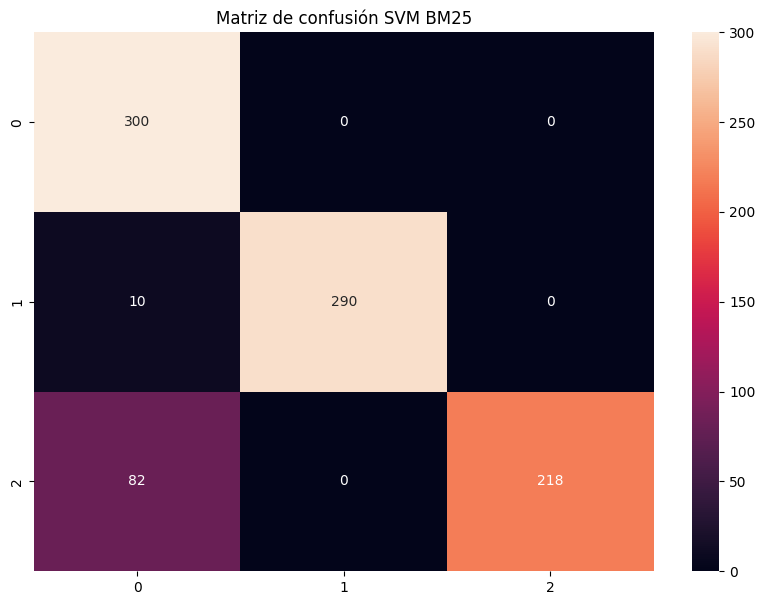

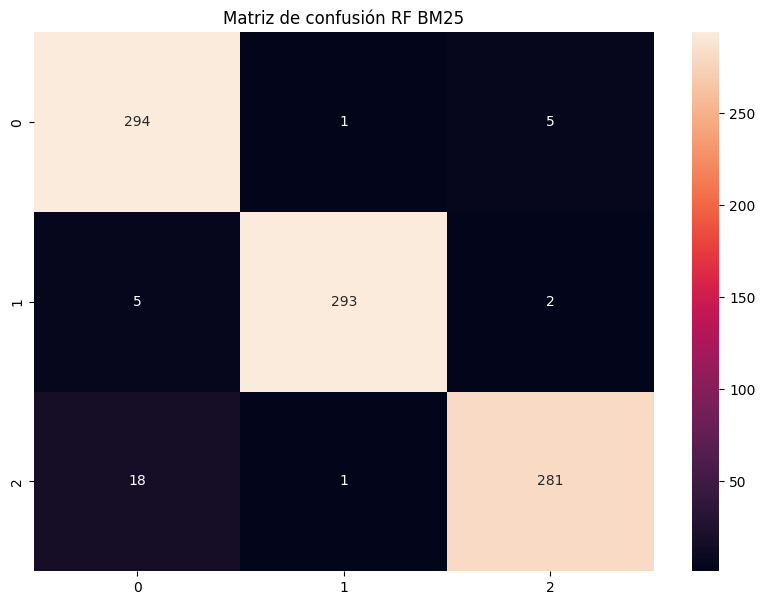

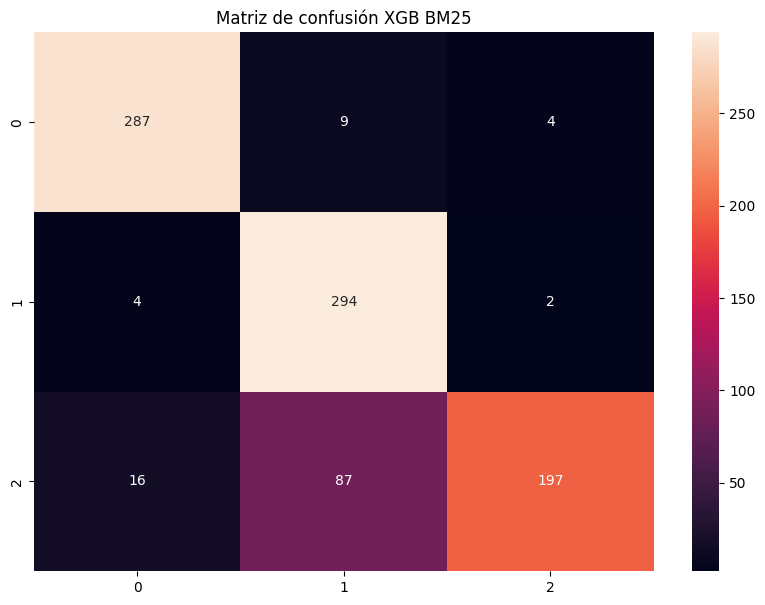

In [13]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# Pintamos la matriz de confusión de BM25
array_bm25 = metrics.confusion_matrix(y_test_encoded, predicted_bm25)

df_cm_bm25 = pd.DataFrame(array_bm25)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm_bm25, annot=True, fmt="d")
plt.title("Matriz de confusión SVM BM25")

array_bm25RF = metrics.confusion_matrix(y_test_encoded, predicted_rf_bm25)
df_cm_bm25RF = pd.DataFrame(array_bm25RF)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm_bm25RF, annot=True, fmt="d")
plt.title("Matriz de confusión RF BM25")

array_bm25XGB = metrics.confusion_matrix(y_test_encoded, predicted_xgb_bm25)
df_cm_bm25XGB = pd.DataFrame(array_bm25XGB)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_bm25XGB, annot=True, fmt="d")
plt.title("Matriz de confusión XGB BM25")

Recordatorio, mapeo de etiquetas originales a valores numéricos:
'ciencia' → 0
'cocina' → 1
'fitness' → 2


#### SVM
El modelo SVM alcanza una **accuracy cercana al 90%**, mostrando un rendimiento sólido en las clases *ciencia* y *cocina*. La clase *cocina* resulta especialmente fácil de identificar, con una precisión perfecta y un recall elevado. Sin embargo, el modelo presenta una debilidad clara en la clase *fitness*, cuyo recall es considerablemente menor (0.73). La matriz de confusión revela que una parte significativa de los videos de fitness se clasifican erróneamente como ciencia, lo que sugiere un solapamiento semántico entre ambas categorías que el SVM no logra separar adecuadamente.

#### Random Forest
Random Forest es el modelo con **mejor desempeño global**, alcanzando una accuracy superior al 96% y valores de precisión, recall y F1-score elevados y equilibrados en las tres clases. La matriz de confusión muestra una reducción significativa de los errores respecto a SVM y XGBoost, especialmente en la clase *fitness*. Este comportamiento indica que Random Forest maneja mejor los patrones no lineales presentes en la representación BM25, convirtiéndose en la opción más robusta y confiable para este problema de clasificación.

#### XGBoost
A pesar de su buen rendimiento en la clase *ciencia* y un recall alto en *cocina*, XGBoost obtiene la **menor accuracy global (≈86%)**. Su principal limitación se encuentra nuevamente en la clase *fitness*, donde el recall cae a 0.66. La matriz de confusión evidencia una confusión importante entre fitness y cocina, lo que sugiere que el modelo no generaliza adecuadamente para esta categoría cuando se utiliza BM25 como representación textual.

#### Comparación general
De forma consistente, la clase *cocina* es la más sencilla de clasificar para los tres modelos, probablemente debido a un vocabulario más específico y distintivo. En contraste, *fitness* presenta mayores dificultades, al compartir términos frecuentes con la categoría *ciencia* (salud, cuerpo, rendimiento), lo que genera confusiones sistemáticas en SVM y XGBoost.


# 3) Extracción del sentimiento de los comentarios

En este apartado usaremos un modelo ya entrenado (BETO) que utiliza word embeddings contextuales para extraer los sentiminetos de los comentarios: 

> Los word embeddings son representaciones densas que palabras que codifican palabras como vectores, de manera que se pueden agrupar palabras con significados parecidos. Además, los word embeddings contextuales permiten que una palabra tenga una codificación distinta según su contexto. (Definición sacada del enunciado de la práctica)

Es realmente sencillo ya que seguiremos el ejemplo visto en la sesión 6 de prácticas

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Ruta del modelo fine-tuneado (BETO adaptado al dataset TASS 2020)
path_sentiment_model = "finiteautomata/beto-sentiment-analysis"

# Carga del tokenizer
tokenizer = AutoTokenizer.from_pretrained(path_sentiment_model)

# Carga del modelo de clasificación
  # El modelo está configurado para clasificación de sentimientos con 3 etiquetas:
    # - 0: Negativo
    # - 1: Neutro
    # - 2: Positivo
sentiment_model = AutoModelForSequenceClassification.from_pretrained(path_sentiment_model)

# Confirmamos la estructura del modelo cargado
print("Modelo de análisis de sentimientos cargado correctamente:")
print(sentiment_model.config.id2label)

/home/jose/master/tgine/P3_Scrapy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Modelo de análisis de sentimientos cargado correctamente:
{0: 'NEG', 1: 'NEU', 2: 'POS'}


Comprobamos que todo funciona correctamente

In [2]:
import torch

# Probamos a clasificar estas frases
textos = ['la película es muy mala y los actores no son los adecuados',
          'me encanta este actor',
          'la pelicula dura 2 horas',
          'estoy encantado con el regalo que me han hecho',
          'hay muchos más muertos por covid',
          'el número de afectados por covid aumenta',
          'vamos a salir de la pandemia',
          'ánimo a todos'
         ]

# Para cada texto
for text in textos:

  # Tokenizamos
  inputs = tokenizer(text, return_tensors="pt")

  # Realizamos inferencia
  with torch.no_grad():
    logits = sentiment_model(**inputs).logits

  # Obtenemos la clase mayoritaria
  predicted_class_id = logits.argmax().item()
  prediction= sentiment_model.config.id2label[predicted_class_id]

  print(text,'=>', prediction)

la película es muy mala y los actores no son los adecuados => NEG
me encanta este actor => POS
la pelicula dura 2 horas => NEU
estoy encantado con el regalo que me han hecho => POS
hay muchos más muertos por covid => NEG
el número de afectados por covid aumenta => NEG
vamos a salir de la pandemia => NEU
ánimo a todos => POS


Creamos la función `add_sentiment()`, que procesa todos los archivos JSON de videos de YouTube almacenados en la estructura de carpetas del proyecto, añadiendo análisis de sentimiento a cada comentario.

La función realiza el siguiente proceso:

1. **Recorrido de la estructura de carpetas**: Itera sobre todas las subcarpetas dentro de `base_dir`

2. **Lectura de archivos JSON**: Para cada carpeta, lee todos los archivos `.json`

3. **Procesamiento de comentarios**: Para cada video dentro de cada canal:
   - Extrae la lista de comentarios
   - Limpia el texto (elimina saltos de línea, espacios extra)

4. **Análisis de sentimiento con BERT**:
   - Tokeniza cada comentario usando el tokenizer del modelo
   - **Manejo de secuencias largas**: BERT tiene un límite de 512 tokens, por lo que si un comentario excede esta longitud, se trunca automáticamente
   - Realiza inferencia sin calcular gradientes (`torch.no_grad()`) para optimizar memoria
   - Obtiene la predicción de sentimiento usando la clase con mayor probabilidad (logits)
   - Mapea el ID de clase predicho a su etiqueta correspondiente (ej: "positive", "negative", "neutral")

5. **Actualización del JSON**: Añade el campo `"sentiment"` a cada comentario con la predicción obtenida

6. **Logging**: Imprime en consola el texto del comentario y su sentimiento predicho para seguimiento del proceso

7. **Guardado**: Guarda los resultados en la carpeta correspondiente, se ha creado una nueva carpeta para cada categoría de video llamada categoria_apartado3, de esta manera podemos entregar los jsons del primer y tercer apartado

In [ ]:
import json
from pathlib import Path

def add_sentiment(base_dir="data"):
    base_path = Path(base_dir)

    # Solo estas carpetas de entrada (evita re-procesar *_apartado3)
    input_folders = {"ciencia", "cocina", "fitness"}

    for folder in base_path.iterdir():
        if not folder.is_dir():
            continue

        folder_name = folder.name
        if folder_name not in input_folders:
            continue

        # Carpeta de salida: data/<tipo>_apartado3
        out_folder = base_path / f"{folder_name}_apartado3"
        out_folder.mkdir(parents=True, exist_ok=True)

        # Lee todos los .json dentro de cada carpeta de entrada
        for json_path in folder.glob("*.json"):
            try:
                with json_path.open("r", encoding="utf-8") as f:
                    channel_data = json.load(f)

                channel_name = channel_data.get("channel", "unknown_channel")
                print(f"Procesando canal: {channel_name} desde {json_path}")

                # Añadimos sentimiento a cada comentario
                for video in channel_data.get("videos", []):
                    comments = video.get("comments", [])
                    for comment in comments:
                        text = comment.get("comment", "")
                        text = text.replace("\n", " ").strip()
                        if not text:
                            continue

                        # Tokenizamos
                        inputs = tokenizer(text, return_tensors="pt")

                        # Truncado a 512 tokens
                        if inputs["input_ids"].shape[1] > 512:
                            inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)

                        # Inferencia
                        with torch.no_grad():
                            logits = sentiment_model(**inputs).logits

                        predicted_class_id = logits.argmax().item()
                        prediction = sentiment_model.config.id2label[predicted_class_id]

                        # Guardamos el sentimiento en el JSON
                        comment["sentiment"] = prediction

                # Guardado en carpeta destino con nombre {channel_name}_p3.json
                safe_name = str(channel_name).strip().replace("/", "_").replace("\\", "_")
                out_path = out_folder / f"{safe_name}_p3.json"

                with out_path.open("w", encoding="utf-8") as f:
                    json.dump(channel_data, f, ensure_ascii=False, indent=2)

                print(f"Guardado: {out_path}")

                

            except (json.JSONDecodeError, OSError) as e:
                print(f"Error leyendo {json_path}: {e}")

add_sentiment()

Procesando canal: el robot de platón desde data/ciencia/el robot de platón_videos.json


Token indices sequence length is longer than the specified maximum sequence length for this model (762 > 512). Running this sequence through the model will result in indexing errors


Guardado: data/ciencia_apartado3/el robot de platón_p3.json
Procesando canal: derivando desde data/ciencia/derivando_videos.json
Guardado: data/ciencia_apartado3/derivando_p3.json
Procesando canal: quantumfracture desde data/ciencia/quantumfracture_videos.json
Guardado: data/ciencia_apartado3/quantumfracture_p3.json
Procesando canal: ciencia de sofa desde data/ciencia/ciencia de sofa_videos.json
Guardado: data/ciencia_apartado3/ciencia de sofa_p3.json
Procesando canal: dotcsv desde data/ciencia/dotcsv_videos.json
Guardado: data/ciencia_apartado3/dotcsv_p3.json
Procesando canal: curiosamente desde data/ciencia/curiosamente_videos.json
Guardado: data/ciencia_apartado3/curiosamente_p3.json
Procesando canal: la gata de Schrödinger desde data/ciencia/la gata de Schrödinger_videos.json
Guardado: data/ciencia_apartado3/la gata de Schrödinger_p3.json
Procesando canal: c de ciencia desde data/ciencia/c de ciencia_videos.json
Guardado: data/ciencia_apartado3/c de ciencia_p3.json
Procesando canal

# 4) Búsqueda de canales similares

En este apartado nos piden aplicar técnicas de similitud de documentos para encontrar que canales se parecen entre sí. Para ello concatenaremos todas las descripciones de los videos de un solo canal y se obtendrá su sentence embedding. Con esto podremos técnicas para ver la similitud entre los vectores.

**FastText** es un modelo de *word embeddings* desarrollado por Facebook que representa las palabras como vectores densos de dimensión fija. A diferencia de modelos clásicos como Word2Vec, FastText incorpora información a nivel de subpalabras (n-gramas de caracteres), lo que le permite manejar de forma más robusta palabras raras, variaciones morfológicas y términos no vistos durante el entrenamiento. Usaremos un modelo FastText preentrenado para obtener representaciones semánticas de los textos.


In [14]:
# Para cada canal, concatenar todas las descripciones de sus vídeos en un solo string

def concatenate_description(base_dir="data"):
    base_path = Path(base_dir)

    descriptions = {}

    # Recorre todas las carpetas dentro de "data/" (fitness, cocina, ciencia, etc.)
    for folder in base_path.iterdir():
        if not folder.is_dir():
            continue

        # Lee todos los .json dentro de cada carpeta
        for json_path in folder.glob("*.json"):
            try:
                with json_path.open("r", encoding="utf-8") as f:
                    channel_data = json.load(f)

                channel_type = channel_data.get("type")
                channel_name = channel_data.get("channel", "unknown_channel")
                descriptions[channel_name] = ["", channel_type]
                for video in channel_data.get("videos", []):
                    description = video.get("description", "")
                    description = description.replace("\n", " ").strip()
                    descriptions[channel_name][0] += " " + description
                    
            except (json.JSONDecodeError, OSError) as e:
                print(f"Error leyendo {json_path}: {e}")

    return descriptions

descriptions = concatenate_description()

In [15]:
import fasttext

# Los word embeddings preentrenados ya se han descargado anteriormente
ft_model = fasttext.load_model ("embeddings-s-model.bin")

Hacemos una prueba del funcionamiento de FastText y comprobamos que funciona correctamente al calcular la **similitud coseno** entre el primer texto y el resto. Esta métrica mide el ángulo entre dos vectores en un espacio de alta dimensión y toma valores entre −1 y 1, donde valores cercanos a 1 indican una alta similitud semántica, valores cercanos a 0 indican poca relación y valores negativos reflejan significados opuestos. Los resultados muestran que los textos relacionados con **procesamiento del lenguaje natural** presentan similitudes más altas entre sí.

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import scipy.sparse as sp

# Definimos un conjunto de textos
textos=[
    'El procesamiento del lenguaje natural (PLN o NLP) es un campo dentro de la inteligencia artificial y la lingüística aplicada que estudia las interacciones mediante uso del lenguaje natural entre los seres humanos y las máquinas. \
Más concretamente se centra en el procesamiento de las comunicaciones humanas, dividiéndolas en partes, e identificando los elementos más relevantes del mensaje.\
Con la Comprensión y Generación de Lenguaje Natural, busca que las máquinas consigan entender, interpretar y manipular el lenguaje humano.',

    'El procesamiento del lenguaje natural (NLP, por sus siglas en inglés) es una rama de la inteligencia artificial que ayuda a las computadoras a entender, interpretar y manipular el lenguaje humano. \
NLP toma elementos prestados de muchas disciplinas, incluyendo la ciencia de la computación y la lingüística computacional, en su afán por cerrar la brecha entre la comunicación humana y el entendimiento de las computadoras.',

    'El procesamiento del lenguaje natural (PLN o NLP) es un campo dentro de la inteligencia artificial y la lingüística aplicada que estudia las interacciones mediante uso del lenguaje natural entre los seres humanos y las máquinas. Más concretamente se centra en el procesamiento de las comunicaciones humanas, dividiéndolas en partes, e identificando los elementos más relevantes del mensaje. Con la Comprensión y Generación de Lenguaje Natural, busca que las máquinas consigan entender, interpretar y manipular el lenguaje humano.',

    'La lingüística computacional es un campo interdisciplinario que se ocupa del desarrollo de formalismos del funcionamiento del lenguaje natural, tales que puedan ser transformados en programas ejecutables para un ordenador. \
Dicho desarrollo se sitúa entre el modelado basado en reglas y el modelado estadístico del lenguaje natural desde una perspectiva computacional, y en él participan lingüistas e informáticos especializados en inteligencia artificial, psicólogos cognoscitivos y expertos en lógica, entre otros.',

    'El aprendizaje automático es un tipo de inteligencia artificial (AI) que proporciona a las computadoras la capacidad de aprender, sin ser programadas explícitamente. El aprendizaje automático se centra en el desarrollo de programas informáticos que pueden cambiar cuando se exponen a nuevos datos.',

    'El  aprendizaje profundo es un tema que cada vez adquiere mayor relevancia en el campo de la inteligencia artificial (IA). Siendo una subcategoría del aprendizaje automático, el aprendizaje profundo trata del uso de redes neuronales para mejorar cosas tales como el reconocimiento de voz, la visión por ordenador y el procesamiento del lenguaje natural. \
Rápidamente se está convirtiendo en uno de los campos más solicitados en informática. \
En los últimos años, el aprendizaje profundo ha ayudado a lograr avances en áreas tan diversas como la percepción de objetos, el procesamiento del lenguaje natural y el reconocimiento de voz (todas ellas áreas especialmente complejas para los investigadores en IA).',

    'El coste de la energía va a subir mucho los próximos meses y la población va a tener que pagar cantidades excesivas a las eléctricas'
]

df_textos = pd.DataFrame(textos)

# Sentence embeddings con FastText
fasttext_sentence_embeddings = df_textos[0].apply(lambda x: ft_model.get_sentence_vector(x)).to_list()

# Convertimos a matriz dispersa CSR para optimizar cálculos (opcional)
if not sp.issparse(fasttext_sentence_embeddings):
    fasttext_sentence_embeddings = sp.csr_matrix(fasttext_sentence_embeddings, dtype=np.float64)

# Similitud del texto 0 con los textos 1..n
results = cosine_similarity(
    fasttext_sentence_embeddings[1::],
    fasttext_sentence_embeddings[0]
).reshape(-1,)

# Imprimimos qué texto se compara (en vez de imprimir solo el vector/array)
base_text = textos[0].replace("\n", " ")
print("Texto base (0):", base_text[:120] + ("..." if len(base_text) > 120 else ""))
print("\nSimilitud del texto base con el resto:\n")

for i, sim in enumerate(results, start=1):
    comp_text = textos[i].replace("\n", " ")
    print(f"(Texto 0) '{base_text[:80]}...'")
    print(f"vs (Texto {i}) '{comp_text[:80]}...' -> cosine_sim = {sim:.4f}\n")

Texto base (0): El procesamiento del lenguaje natural (PLN o NLP) es un campo dentro de la inteligencia artificial y la lingüística apli...

Similitud del texto base con el resto:

(Texto 0) 'El procesamiento del lenguaje natural (PLN o NLP) es un campo dentro de la intel...'
vs (Texto 1) 'El procesamiento del lenguaje natural (NLP, por sus siglas en inglés) es una ram...' -> cosine_sim = 0.9818

(Texto 0) 'El procesamiento del lenguaje natural (PLN o NLP) es un campo dentro de la intel...'
vs (Texto 2) 'El procesamiento del lenguaje natural (PLN o NLP) es un campo dentro de la intel...' -> cosine_sim = 0.9998

(Texto 0) 'El procesamiento del lenguaje natural (PLN o NLP) es un campo dentro de la intel...'
vs (Texto 3) 'La lingüística computacional es un campo interdisciplinario que se ocupa del des...' -> cosine_sim = 0.9765

(Texto 0) 'El procesamiento del lenguaje natural (PLN o NLP) es un campo dentro de la intel...'
vs (Texto 4) 'El aprendizaje automático es un tipo de inteligencia

Para ver la similitud entre todos los canales calculamos una matriz canal-canal con la similitud coseno para cada combinación de canales. Esta matriz se visualiza mediante un **mapa de calor (heatmap)**, lo que facilita la identificación visual de grupos de canales con contenidos afines y posibles solapamientos temáticos.

Con el objetivo de explorar la estructura del espacio semántico (de los embeddings de la descripción de cada canal) de forma visual, se aplica una **reducción de dimensionalidad en dos etapas**. Primero se utiliza **PCA (Análisis de Componentes Principales)** para reducir la dimensionalidad de los embeddings originales, posteriormente, se aplica **t-SNE**, una técnica no lineal especialmente adecuada para la visualización, que proyecta los canales en un espacio bidimensional preservando las relaciones locales de similitud. Los canales se representan en un gráfico 2D, coloreados según su tipo, lo que permite evaluar si canales del mismo dominio tienden a agruparse de forma coherente.

Finalmente, a partir de la matriz de similitud coseno, se implementa un procedimiento para identificar los **canales más similares a cada canal dado** (Top-K similares).


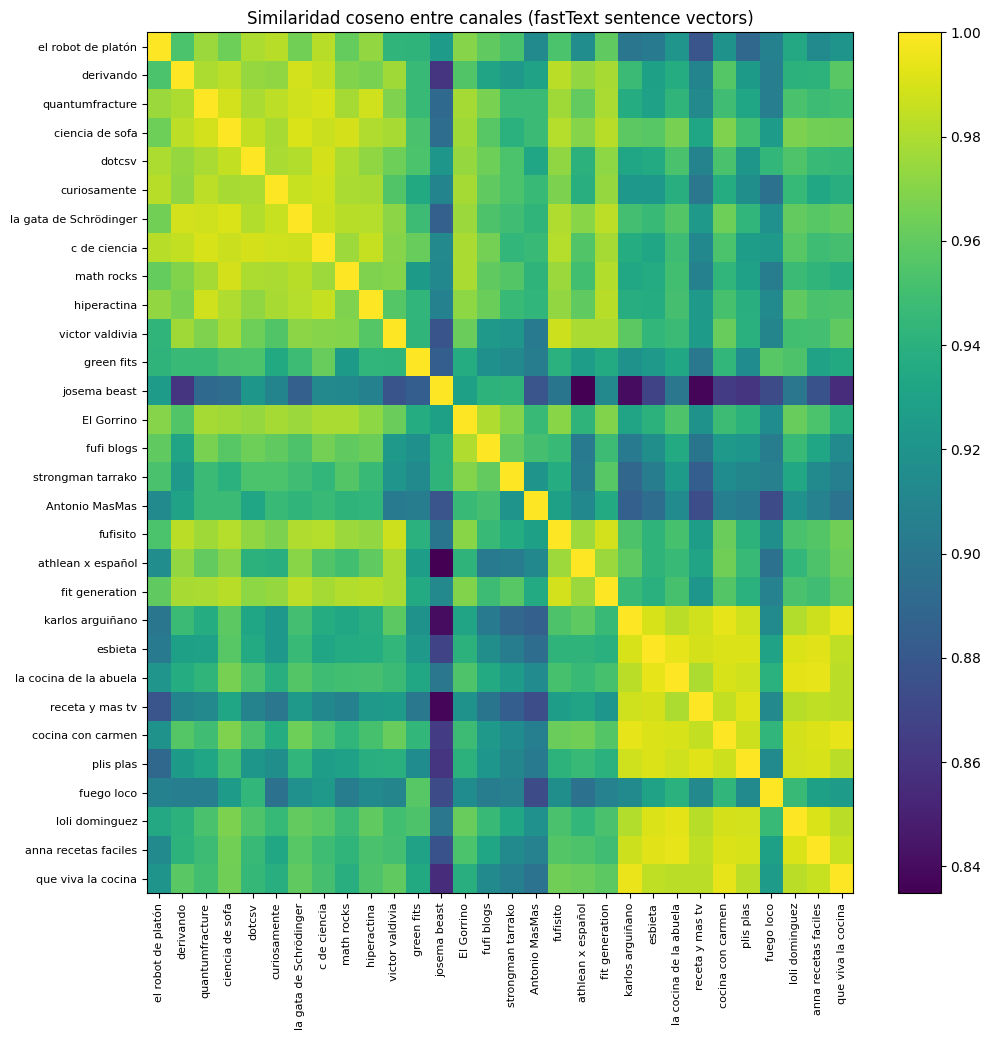

/tmp/ipykernel_1330/1716787768.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(tipos))


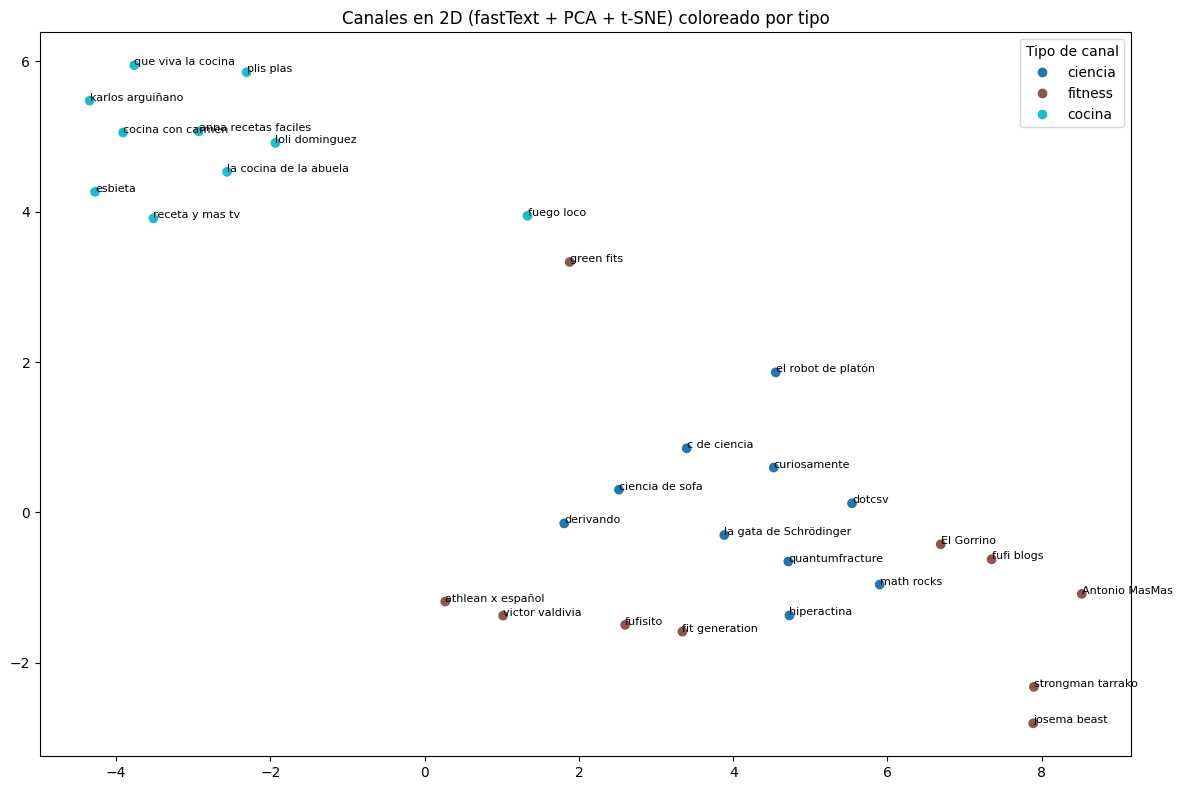

=== Top similares por canal ===

el robot de platón:
  -> c de ciencia: 0.9825
  -> curiosamente: 0.9824
  -> dotcsv: 0.9795
  -> quantumfracture: 0.9749
  -> hiperactina: 0.9731

derivando:
  -> la gata de Schrödinger: 0.9885
  -> c de ciencia: 0.9847
  -> ciencia de sofa: 0.9837
  -> fufisito: 0.9827
  -> quantumfracture: 0.9797

quantumfracture:
  -> c de ciencia: 0.9899
  -> ciencia de sofa: 0.9887
  -> hiperactina: 0.9884
  -> la gata de Schrödinger: 0.9879
  -> curiosamente: 0.9835

ciencia de sofa:
  -> la gata de Schrödinger: 0.9908
  -> math rocks: 0.9896
  -> quantumfracture: 0.9887
  -> c de ciencia: 0.9869
  -> dotcsv: 0.9846

dotcsv:
  -> c de ciencia: 0.9893
  -> ciencia de sofa: 0.9846
  -> la gata de Schrödinger: 0.9812
  -> el robot de platón: 0.9795
  -> math rocks: 0.9794

curiosamente:
  -> c de ciencia: 0.9879
  -> la gata de Schrödinger: 0.9860
  -> quantumfracture: 0.9835
  -> el robot de platón: 0.9824
  -> dotcsv: 0.9789

la gata de Schrödinger:
  -> ciencia de

In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt


def limpiar_texto(s: str) -> str:
    if s is None:
        return ""
    return " ".join(str(s).split())

def canal_embedding(texto: str) -> np.ndarray:
    return ft_model.get_sentence_vector(texto)

#  DATAFRAME + EMBEDDINGS
df = pd.DataFrame(
    [(canal, limpiar_texto(info[0]), str(info[1])) for canal, info in descriptions.items()],
    columns=["canal", "texto", "tipo"]
)

X = np.vstack(df["texto"].apply(canal_embedding).to_numpy())  # (n_canales, dim)


# Simililaridad coseno entre canales
S = cosine_similarity(X, X)
sim_df = pd.DataFrame(S, index=df["canal"], columns=df["canal"])

# Heatmap de similitud coseno
n = len(df)
fig_w = min(30, max(10, 0.35 * n))
fig_h = min(30, max(8, 0.35 * n))

plt.figure(figsize=(fig_w, fig_h))
plt.imshow(S, aspect="auto")
plt.colorbar()
plt.title("Similaridad coseno entre canales (fastText sentence vectors)")
plt.xticks(range(n), df["canal"], rotation=90, fontsize=8)
plt.yticks(range(n), df["canal"], fontsize=8)
plt.tight_layout()
plt.show()

# Reducción de dimensionalidad PCA + t-SNE
X_pca = PCA(n_components=min(50, X.shape[1]), random_state=0).fit_transform(X)

X_2d = TSNE(
    n_components=2,
    perplexity=min(30, max(5, n // 3)),
    init="pca",
    learning_rate="auto",
    random_state=0
).fit_transform(X_pca)

# Mapeo tipo -> índic
tipos = df["tipo"].astype(str).unique()
tipo2idx = {t: i for i, t in enumerate(tipos)}
c = df["tipo"].astype(str).map(tipo2idx).to_numpy()

cmap_name = "tab10" if len(tipos) <= 10 else "tab20"
cmap = plt.cm.get_cmap(cmap_name, len(tipos))

plt.figure(figsize=(12, 8))
sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=c, cmap=cmap)

handles, _ = sc.legend_elements(num=len(tipos))
plt.legend(handles, tipos, title="Tipo de canal", loc="best")

texts = [plt.text(X_2d[i, 0], X_2d[i, 1], df["canal"].iloc[i], fontsize=8) for i in range(n)]

def repel_texts(texts, iters=300, min_dist=0.05):
    for _ in range(iters):
        moved = False
        for i in range(len(texts)):
            xi, yi = texts[i].get_position()
            for j in range(i + 1, len(texts)):
                xj, yj = texts[j].get_position()
                dx = xi - xj
                dy = yi - yj
                d2 = dx*dx + dy*dy
                if d2 < (min_dist * min_dist):
                    shift_x = 0.5 * min_dist if dx >= 0 else -0.5 * min_dist
                    shift_y = 0.5 * min_dist if dy >= 0 else -0.5 * min_dist
                    texts[i].set_position((xi + shift_x, yi + shift_y))
                    texts[j].set_position((xj - shift_x, yj - shift_y))
                    moved = True
        if not moved:
            break

repel_texts(texts, iters=300, min_dist=0.05)

plt.title("Canales en 2D (fastText + PCA + t-SNE) coloreado por tipo")
plt.tight_layout()
plt.show()

# Top - k similares por canal
def top_k_similares(sim_df: pd.DataFrame, canal: str, k: int = 5):
    s = sim_df.loc[canal].drop(canal).sort_values(ascending=False)
    return s.head(k)

print("=== Top similares por canal ===")
for canal in sim_df.index:
    top = top_k_similares(sim_df, canal, k=5)
    print(f"\n{canal}:")
    for otro, val in top.items():
        print(f"  -> {otro}: {val:.4f}")